In [1]:
import pandas as pd

## Collecting Raw Data

In [2]:
plant1_gen = pd.read_csv("../data/raw/Plant_1_Generation_Data.csv")
plant1_weather = pd.read_csv("../data/raw/Plant_1_Weather_Sensor_Data.csv")

plant2_gen = pd.read_csv("../data/raw/Plant_2_Generation_Data.csv")
plant2_weather = pd.read_csv("../data/raw/Plant_2_Weather_Sensor_Data.csv")

print("✅ All raw datasets loaded successfully!")


✅ All raw datasets loaded successfully!


## Data Cleaning

In [3]:
# Plant1
plant1_gen.dropna(inplace=True)
plant1_weather.dropna(inplace=True)

plant1_gen.drop_duplicates(inplace=True)
plant1_weather.drop_duplicates(inplace=True)

plant1_gen['DATE_TIME'] = pd.to_datetime(plant1_weather['DATE_TIME'])
plant1_weather['DATE_TIME'] = pd.to_datetime(plant1_gen['DATE_TIME'])


# Plant2
plant2_gen.dropna(inplace=True)
plant2_weather.dropna(inplace=True)

plant2_gen.drop_duplicates(inplace=True)
plant1_weather.drop_duplicates(inplace=True)

plant2_gen['DATE_TIME'] = pd.to_datetime(plant2_weather['DATE_TIME'])
plant2_weather['DATE_TIME'] = pd.to_datetime(plant2_gen['DATE_TIME'])

## Merge Generation + Weather Data (per Plant)

In [4]:
plant1_merged = pd.merge(plant1_gen, plant1_weather, on='DATE_TIME', how='inner')
plant2_merged = pd.merge(plant2_gen, plant2_weather, on='DATE_TIME', how='inner')

# Save processed versions
plant1_merged.to_csv("../data/processed/Plant_1_Final.csv", index=False)
plant2_merged.to_csv("../data/processed/Plant_2_Final.csv", index=False)


## Combine Both Plants

In [5]:
combined_df = pd.concat([plant1_merged,plant2_merged],ignore_index=True)
combined_df.to_csv("../data/processed/Combined_Solar_Data.csv",index=False)

## Preprocess Final Data for ML


In [ ]:

import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score



In [44]:
combined_df['DATE_TIME'] = pd.to_datetime(combined_df['DATE_TIME'])
combined_df['HOUR'] = combined_df['DATE_TIME'].dt.hour
combined_df['DAY_OF_YEAR'] = combined_df['DATE_TIME'].dt.dayofyear

## Prepare Training Data

In [57]:
features = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'HOUR', 'DAY_OF_YEAR']
target = 'DC_POWER'

X = combined_df[features]
y = combined_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



## Train ML Model

In [58]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = model.predict(X_test_scaled)
print("✅ R2 Score:", r2_score(y_test, y_pred))


✅ R2 Score: 0.8752022931577969


## Saving ML Model

In [59]:
joblib.dump(model, "../models/model.pkl")
joblib.dump(scaler, "../models/scaler.pkl")

print("✅ Model and Scaler saved successfully!")

✅ Model and Scaler saved successfully!


## Predict and Plot

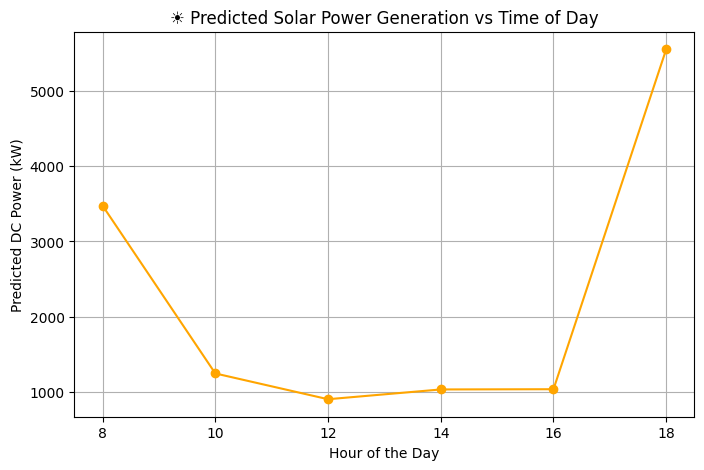

In [ ]:

model = joblib.load("../models/model.pkl")
scaler = joblib.load("../models/scaler.pkl")

new_data = pd.DataFrame({
    'AMBIENT_TEMPERATURE': [28, 30, 32, 35, 37, 39],
    'MODULE_TEMPERATURE': [40, 42, 45, 48, 50, 53],
    'IRRADIATION': [500, 650, 800, 950, 1000, 1050],
    'HOUR': [8, 10, 12, 14, 16, 18],
    'DAY_OF_YEAR': [210]*6
})

scaled_data = scaler.transform(new_data)
predictions = model.predict(scaled_data)

plt.figure(figsize=(8,5))
plt.plot(new_data['HOUR'], predictions, marker='o', color='orange')
plt.title("☀️ Predicted Solar Power Generation vs Time of Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Predicted DC Power (kW)")
plt.grid(True)
plt.show()

